# 🧠 Random Forest classifier for ASL hand landmarks (MediaPipe-based)

This notebook trains and optimizes a Random Forest classifier on hand landmark vectors (60-D) extracted from MediaPipe. The goal is to classify ASL alphabet letters from static hand poses, using a clean, vectorized dataset previously generated.

We will:
- Load preprocessed training/test data (70/30 split)
- Fit a default Random Forest baseline
- Optimize hyperparameters using GridSearchCV
- Diagnose model learning behavior with learning/validation curves
- Evaluate generalization on the test set
- Visualize confusion matrix and feature importances

The full dataset includes 28 classes: A–Z, space, delete, nothing.


In [1]:
# ──────────────────────────────────────────────────────────────
# 📦 Core dependencies
import os
import time
import numpy as np
import pandas as pd

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# 🤖 Model and preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve,
    cross_validate, StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.preprocessing import LabelEncoder

# ⚙️ Utility
import joblib
from pathlib import Path


In [2]:
N_CORES = max(1, (os.cpu_count() or 2) - 2)
RANDOM_SEED = 42

### 📂 Dataset Loading

**Note:** We assume the preprocessed and vectorized datasets already exist as `train.csv` and `test.csv` under the `../data/processed/` directory.  
These CSVs contain the extracted 3D hand landmark features (60 floats per sample) and their corresponding labels.


In [3]:
train_df = pd.read_csv("../data/processed/processed_60_features/train80.csv")
test_df  = pd.read_csv("../data/processed/processed_60_features/test20.csv")

X_train, y_train = train_df.drop("label", axis=1).values, train_df["label"].values
X_test,  y_test  = test_df.drop("label",  axis=1).values, test_df["label"].values

# Encode string labels (A, B, …) → integers 0-27
enc = LabelEncoder().fit(y_train)
y_train = enc.transform(y_train)
y_test  = enc.transform(y_test)

print(f"[INFO] Loaded: {len(X_train)} train samples | {len(X_test)} test samples")

[INFO] Loaded: 50930 train samples | 12733 test samples


### 🔍 Initial Hyperparameter Search with RandomizedSearchCV

In this section, we will search for a reasonably good configuration of the Random Forest classifier using `RandomizedSearchCV`.  
This will help us explore a range of hyperparameter combinations and identify a strong baseline model before moving on to more detailed tuning.

In [8]:
#Param grids
param_grid = {
    "n_estimators":      [100, 200, 300],  
    "max_depth":         [None, 20],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf":  [1, 2, 5],  
    "max_features":      ["sqrt", 0.5],  
}

In [9]:
rf_base = RandomForestClassifier(
    bootstrap=True,          # bagging enabled
    oob_score=False,         # OOB disabled for grid search
    class_weight="balanced", # handle class imbalance
    random_state=RANDOM_SEED,
    n_jobs=N_CORES
)

search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter = 20, 
    cv=5,                        # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=1,
    verbose=0,                   # show progress
    return_train_score=True
)

search.fit(X_train, y_train)

print("Best CV accuracy :", search.best_score_)
print("Best parameters  :", search.best_params_)

# keep best model for later steps
rf_best = search.best_estimator_

/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-langua

Best CV accuracy : 0.9898488120950324
Best parameters  : {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-langua

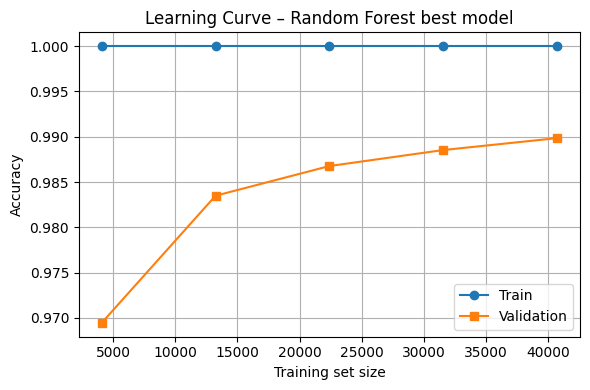

In [10]:
# Compute learning curve (5 points from 10 % to 100 % of the training set)
train_sizes, train_scores, val_scores = learning_curve(
    estimator=rf_best,          # best model from GridSearchCV
    X=X_train, y=y_train,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=N_CORES
)

# Calculate mean accuracy across folds
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, label="Train", marker="o")
plt.plot(train_sizes, val_mean,   label="Validation", marker="s")
plt.title("Learning Curve – Random Forest best model")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Best parameters from RandomizedSearchCV
best_params = {
    "n_estimators":      300,
    "min_samples_split": 2,
    "min_samples_leaf":  1,
    "max_features":      "sqrt",
    "max_depth":         40,
    "bootstrap":         True,
    "class_weight":      "balanced",
    "random_state":      42,
    "n_jobs":            N_CORES
}

In [15]:
# Set parameter to study
param_to_study = "min_samples_leaf"  # Change this to any key below

# Define search space for different hyperparameters
param_grid = {
    "n_estimators":      [100, 200, 300, 400],
    "max_depth":         [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf":  [1, 2, 5, 10],
}

# Get param range
param_range = param_grid[param_to_study]

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Containers
fit_times, val_scores, train_scores = [], [], []

params = best_params.copy()
params.pop(param_to_study, None)

for value in param_range:
    model = RandomForestClassifier(**params, **{param_to_study: value})
    cv_result = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring="accuracy",
        return_train_score=True,
        n_jobs=1
    )
    fit_times.append(cv_result["fit_time"].mean())
    val_scores.append(cv_result["test_score"].mean())
    train_scores.append(cv_result["train_score"].mean())

/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-language-letters/lib/python3.10/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/mapegu/miniconda3/envs/sign-langua

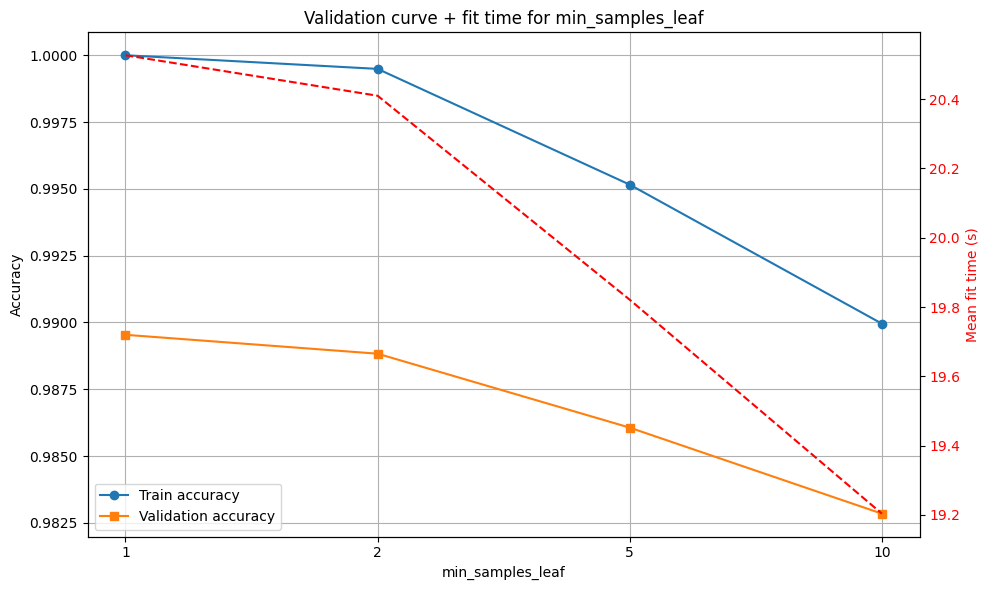

In [16]:
# Labels for x-axis
x_labels = [str(x) for x in param_range]
x_pos = np.arange(len(param_range))

# Plot: Accuracy and Fit time
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(x_pos, train_scores, "o-", label="Train accuracy")
ax1.plot(x_pos, val_scores, "s-", label="Validation accuracy")
ax1.set_xlabel(param_to_study)
ax1.set_ylabel("Accuracy")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels)
ax1.legend(loc="lower left")
ax1.grid(True)

# Fit time (secondary axis)
ax2 = ax1.twinx()
ax2.plot(x_pos, fit_times, "r--", label="Fit time")
ax2.set_ylabel("Mean fit time (s)", color="r")
ax2.tick_params(axis="y", labelcolor="r")

plt.title(f"Validation curve + fit time for {param_to_study}")
plt.tight_layout()
plt.show()

In [7]:
final_params = {
    "n_estimators": 300,
    "min_samples_split": 2,
    "max_depth": None,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "bootstrap": True,
    "class_weight": "balanced",
    "random_state": 42,
    "n_jobs": -1
}

rf_best = RandomForestClassifier(**final_params).fit(X_train, y_train)

[ 4 24 18 ... 22 16 18]
[INFO] Test accuracy : 0.9914
[INFO] Avg inference : 0.020 ms / sample (50908.9 samples/sec)


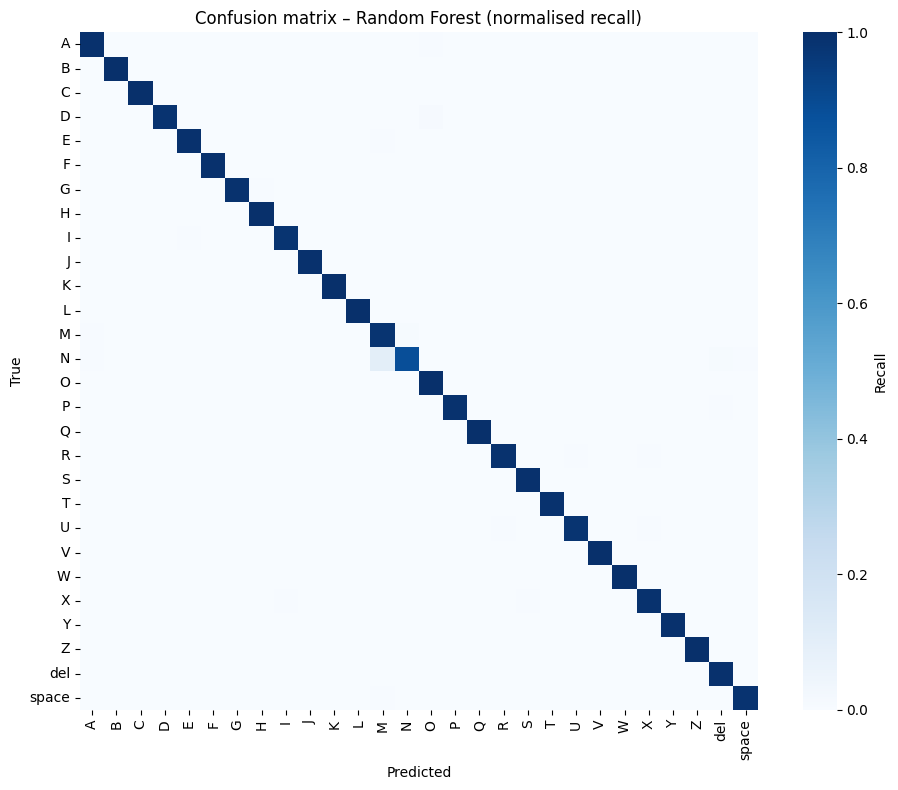


              precision    recall  f1-score   support

           A       0.99      0.99      0.99       438
           B       1.00      1.00      1.00       442
           C       1.00      1.00      1.00       398
           D       1.00      0.99      0.99       492
           E       0.99      1.00      0.99       462
           F       0.99      0.99      0.99       575
           G       1.00      0.99      1.00       488
           H       0.99      1.00      1.00       478
           I       0.99      0.98      0.99       476
           J       1.00      0.99      0.99       516
           K       1.00      1.00      1.00       540
           L       1.00      1.00      1.00       506
           M       0.90      0.98      0.94       312
           N       0.98      0.88      0.93       256
           O       0.98      1.00      0.99       453
           P       1.00      0.99      1.00       408
           Q       1.00      1.00      1.00       418
           R       0.99   

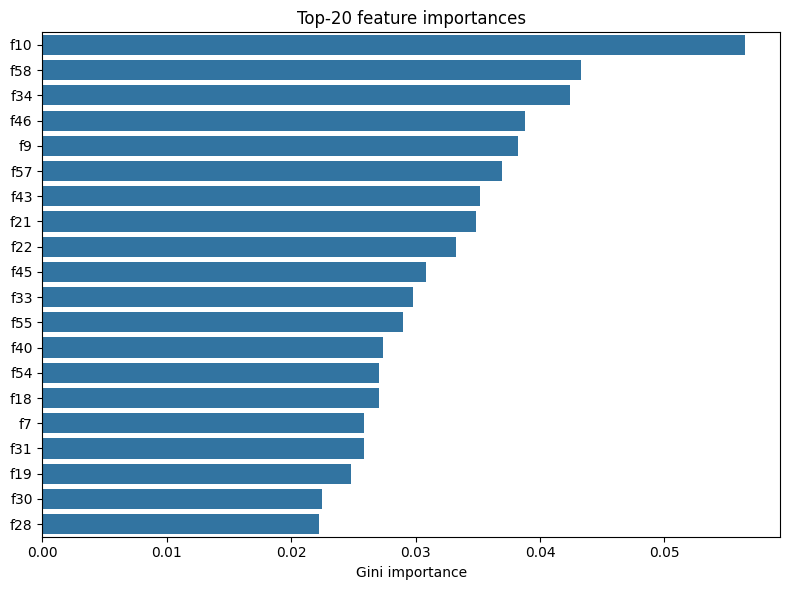

In [8]:
# 📊 Final evaluation on test20  (held–out 20 % test set)
# ------------------------------------------------------------------
# Requires:
#   • rf_best .............. trained RandomForestClassifier
#   • X_test , y_test ...... numpy arrays for the 20 % test split
#   • enc .................. fitted LabelEncoder (to get class names)
# ── 1. Inference-time benchmark ───────────────────────────────────
start = time.perf_counter()
y_pred = rf_best.predict(X_test)
elapsed = time.perf_counter() - start
avg_ms = (elapsed / len(X_test)) * 1_000

print(f"[INFO] Test accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"[INFO] Avg inference : {avg_ms:.3f} ms / sample "
      f"({1/avg_ms*1000:.1f} samples/sec)")

# ── 2. Confusion matrix (normalised) ──────────────────────────────
class_names = enc.inverse_transform(np.unique(y_test))
cm = confusion_matrix(y_test, y_pred, normalize="true")

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Recall"},
    square=True
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix – Random Forest (normalised recall)")
plt.tight_layout()
plt.show()

print("\n" + classification_report(y_test, y_pred, target_names=class_names))

# ── 3. Feature-importance plot (top-20) ───────────────────────────
importances = rf_best.feature_importances_
idx_sorted = np.argsort(importances)[::-1][:20]      # top-20 indices
feat_labels = [f"f{i}" for i in idx_sorted]
feat_values = importances[idx_sorted]

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_values, y=feat_labels, orient="h")
plt.xlabel("Gini importance")
plt.title("Top-20 feature importances")
plt.tight_layout()
plt.show()

In [9]:
joblib.dump(rf_best, "../models/random_forest_asl.joblib")
print("✔️ Modelo guardado como random_forest_asl.joblib")
joblib.dump(enc, "../models/encoder_asl.joblib")
print("✔️ Encoder guardado como encoder_asl.joblib")


✔️ Modelo guardado como random_forest_asl.joblib
✔️ Encoder guardado como encoder_asl.joblib
